In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt
from flax import nnx

from neuralbridge.sde_examples import SinusoidalSDE, SinusoidalAuxiliarySDE
from neuralbridge.base import GuidedProposalSDE, NeuralBridgeSDE
from neuralbridge.sde_solver import SDESolver
from neuralbridge.pcn import PCNSampler
from neuralbridge.trainer import train

### Experiment 1

In [3]:
params = {
    'beta1': 2.0,
    'beta2': 2.0,
    'sigma': 0.5
}

prior_sde = SinusoidalSDE(params)
auxiliary_sde = SinusoidalAuxiliarySDE(params)

observations = {
    'v': jnp.array([jnp.pi / 2.0]),
    'L': jnp.eye(1),
    'Sigma': jnp.eye(1) * 1e-10,
}

T = 1.0
n_steps = 100
ts = jnp.linspace(0.0, T, n_steps)

guided_proposal_sde = GuidedProposalSDE(prior_sde, auxiliary_sde, observations, ts, eq_type="uLM")

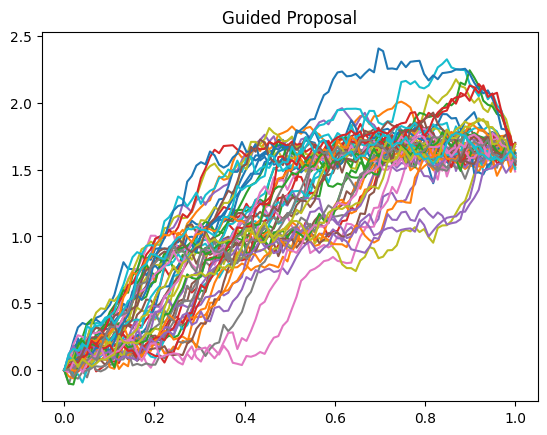

In [4]:
rng_key = jr.PRNGKey(42)
x0 = jnp.array([0.0])
batch_size = 50

guided_proposal_sde_solver = SDESolver(guided_proposal_sde, method='milstein')
guided_proposal_sde_traj = guided_proposal_sde_solver.batch_solve(rng_key, x0, ts, batch_size)

for i in range(batch_size):
    plt.plot(ts, guided_proposal_sde_traj[i])

plt.title("Guided Proposal")
plt.show()

In [8]:
nn_config = {
    'nn_type': 'MLPSmall',
    'hidden_dims': (20, 20, 20),
    'act_type': 'lipswish',
    'rngs': nnx.Rngs(42)
}

neural_bridge_sde = NeuralBridgeSDE(guided_proposal_sde, nn_config)

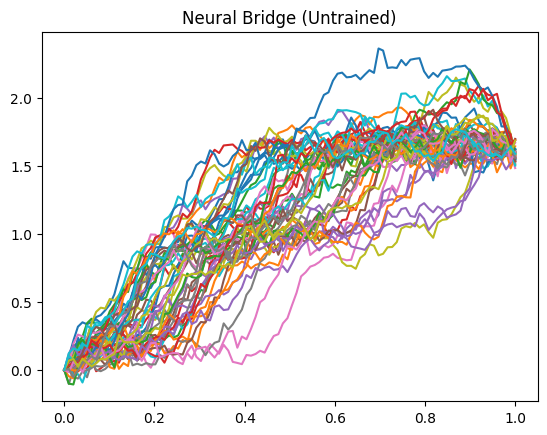

In [9]:
neural_bridge_sde_solver = SDESolver(neural_bridge_sde, method='milstein')
neural_bridge_sde_traj = neural_bridge_sde_solver.batch_solve(rng_key, x0, ts, batch_size)

for i in range(batch_size):
    plt.plot(ts, neural_bridge_sde_traj[i])

plt.title("Neural Bridge (Untrained)")
plt.show()

In [11]:
train_config = {
    'ckpt_dir': '../assets/ckpts/neural_bridge/sin_bridge',
    'lr': 1e-3,
    'batch_size': 50,
    'n_iters': 5000,
    'patience': None
}

losses = train(neural_bridge_sde, x0, ts, train_config, rngs=nnx.Rngs(42))

Step [  100 / 5000]: loss = -3.815411, Time elapsed: 0.928s
Step [  200 / 5000]: loss = -4.367809, Time elapsed: 1.216s
Step [  300 / 5000]: loss = -4.453989, Time elapsed: 1.546s
Step [  400 / 5000]: loss = -4.301093, Time elapsed: 1.914s
Step [  500 / 5000]: loss = -4.508680, Time elapsed: 2.205s
Step [  600 / 5000]: loss = -4.635237, Time elapsed: 2.503s
Step [  700 / 5000]: loss = -4.633015, Time elapsed: 2.801s
Step [  800 / 5000]: loss = -4.786882, Time elapsed: 3.103s
Step [  900 / 5000]: loss = -4.816924, Time elapsed: 3.400s
Step [ 1000 / 5000]: loss = -4.741622, Time elapsed: 3.695s
Step [ 1100 / 5000]: loss = -4.754108, Time elapsed: 3.989s
Step [ 1200 / 5000]: loss = -4.730179, Time elapsed: 4.281s
Step [ 1300 / 5000]: loss = -4.724449, Time elapsed: 4.572s
Step [ 1400 / 5000]: loss = -4.800577, Time elapsed: 4.868s
Step [ 1500 / 5000]: loss = -4.808905, Time elapsed: 5.162s
Step [ 1600 / 5000]: loss = -4.825758, Time elapsed: 5.460s
Step [ 1700 / 5000]: loss = -4.739934, T

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


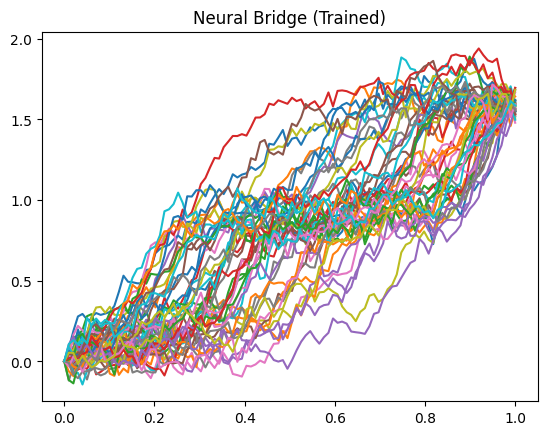

In [12]:
neural_bridge_sde_solver_trained = SDESolver(neural_bridge_sde, method='milstein')
neural_bridge_sde_traj_trained = neural_bridge_sde_solver_trained.batch_solve(rng_key, x0, ts, batch_size)

for i in range(batch_size):
    plt.plot(ts, neural_bridge_sde_traj_trained[i])

plt.title("Neural Bridge (Trained)")
plt.show()

In [20]:
pcn_sampler = PCNSampler(guided_proposal_sde, eta=0.9)

pcn_traj, _ = pcn_sampler.sample(
    x0, ts, n_iters=10000, n_samples=batch_size, n_burn_in=5000, rng_key=rng_key
)

100%|██████████| 10000/10000 [00:02<00:00, 3458.58it/s]

acceptance rate (post-burn-in): 49.46%


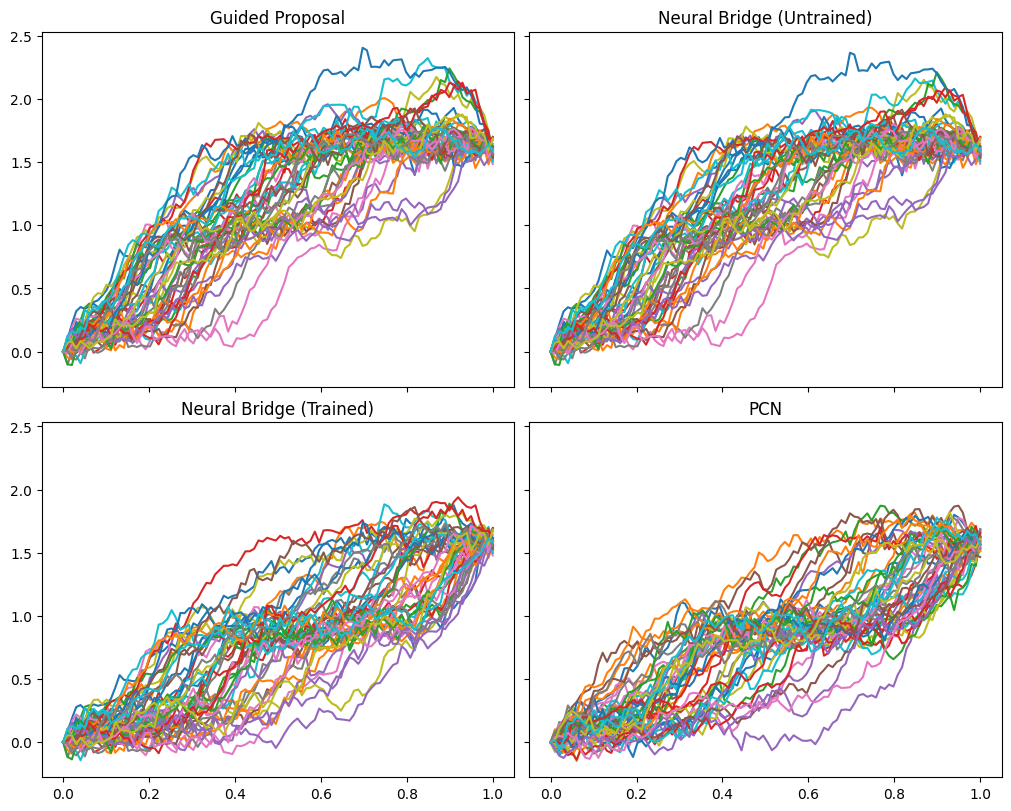

In [25]:
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 8), layout='constrained')

for i in range(batch_size):
    axes[0, 0].plot(ts, guided_proposal_sde_traj[i])
    axes[0, 1].plot(ts, neural_bridge_sde_traj[i])
    axes[1, 0].plot(ts, neural_bridge_sde_traj_trained[i])
    axes[1, 1].plot(ts, pcn_traj[i])

axes[0, 0].set_title("Guided Proposal")
axes[0, 1].set_title("Neural Bridge (Untrained)")
axes[1, 0].set_title("Neural Bridge (Trained)")
axes[1, 1].set_title("PCN")
plt.show()

### Experiment 2